<a href="https://colab.research.google.com/github/ai-loli/CLASSIFICATION-OF-ANTS-AND-BEES-USING-DEEP-LEARNING/blob/main/Classification_of_ants_and_bees_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the libraries
import torch                            
import torch.nn as nn                   
import torch.optim as optim             
from torch.optim import lr_scheduler    
import torchvision                      
from torch.autograd import Variable     
from torchvision import datasets, models, transforms  
import os                              
import numpy as np                    

In [ ]:
# By default, GPU support is built if CUDA is found and torch.cuda.is_available() is true
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [ ]:
#download the images (kaggle)
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-11-26 12:33:51--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.97.116, 13.225.97.95, 13.225.97.19, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.97.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  71.1MB/s    in 0.6s    

2020-11-26 12:33:51 (71.1 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/

In [ ]:
# Data Augmentation and Normalization for training
data_transforms = {
    'train': transforms.Compose([             
        transforms.RandomResizedCrop(224),    
        transforms.RandomHorizontalFlip(),    
        transforms.ToTensor(),                
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                                                           
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),               
        transforms.CenterCrop(224),           
        transforms.ToTensor(),                
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
}

In [ ]:
#Loading the dataset
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,           
                                              shuffle=True) for x in ['train', 'val']}    

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))  
print("There are {} batches in the test set".format(len(dataloaders['val'])))  
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['val']))

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


In [ ]:
# Load the ResNet
# We will load 18 layers that is why it is called ResNet18
model_conv = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#Freeze the weights and previous layers in the network  
for param in model_conv.parameters():  
    param.requires_grad = False

In [ ]:
model_conv.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
#Get the number of inputs of the last layer (or number of neurons in the layer preceeding the last layer)
num_ftrs = model_conv.fc.in_features
#Reconstruct the last layer (output layer) to have only two classes 
model_conv.fc = nn.Linear(num_ftrs, 2)


In [ ]:
model_conv.fc

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
# Move the model to GPU for better and more general graphic processing
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [ ]:
# Steps during training
iteration = 0
# That defines how many correct predictions we have
correct = 0 
for inputs,labels in dataloaders['train']:
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    print("Labels are: {}".format(labels))
    output = model_conv(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape",predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:",correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([1, 1, 0, 0], device='cuda:0')
Output Tensor: tensor([[ 0.9660, -0.0928],
        [ 0.4803, -0.2535],
        [ 0.6552, -0.6531],
        [-0.3231, -0.0236]], device='cuda:0', grad_fn=<AddmmBackward>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 1], device='cuda:0')
Predicted Shape torch.Size([4])
Correct Predictions: tensor(1, device='cuda:0')


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) # To use torch.optim you have to construct an optimizer object, that will hold the current state and will update the parameters based on the computed gradients
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 11
for epoch in range (num_epochs): 
    exp_lr_scheduler.step()       
    correct = 0
    for images,labels in dataloaders['train']: 
        images = Variable(images)        
        labels = Variable(labels)
        if torch.cuda.is_available():    
            images = images.cuda()
            labels = labels.cuda()
            
        optimizer.zero_grad()             
        outputs = model_conv(images)      
        loss = criterion(outputs, labels) 
        loss.backward()                   
        optimizer.step()                 
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == labels).sum()  
        
    train_acc = 100 * correct // dataset_sizes['train']    
    print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {}%' 
            .format(epoch+1, num_epochs, loss.item(), train_acc))

Epoch [1/11], Loss: 0.0432, Train Accuracy: 94%
Epoch [2/11], Loss: 0.2288, Train Accuracy: 94%
Epoch [3/11], Loss: 0.0754, Train Accuracy: 94%
Epoch [4/11], Loss: 0.1403, Train Accuracy: 95%
Epoch [5/11], Loss: 0.0231, Train Accuracy: 94%
Epoch [6/11], Loss: 0.0830, Train Accuracy: 97%
Epoch [7/11], Loss: 0.2233, Train Accuracy: 95%
Epoch [8/11], Loss: 0.2837, Train Accuracy: 97%
Epoch [9/11], Loss: 0.0757, Train Accuracy: 94%
Epoch [10/11], Loss: 0.0102, Train Accuracy: 95%
Epoch [11/11], Loss: 0.0278, Train Accuracy: 94%


In [ ]:
# Test the model
model_conv.eval()  
with torch.no_grad():       
    correct = 0
    total = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)    
        _, predicted = torch.max(outputs.data, 1)     
        total += labels.size(0)                       
        correct += (predicted == labels).sum().item() 

    print('Test Accuracy: {:.3f} %'.format(100 * correct / total))

Test Accuracy: 94.118 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


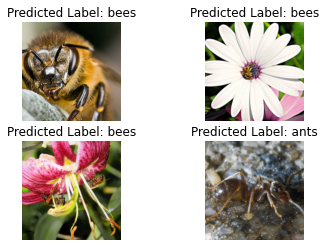

In [ ]:
#Visualize some predictions 
import matplotlib.pyplot as plt     
fig = plt.figure()                 
shown_batch = 0
index = 0
with torch.no_grad():               
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:        
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            
        _, preds = torch.max(outputs, 1)                        
        
        # show the images
        for i in range(4):                                      
            index += 1                                          
            ax = plt.subplot(2,2,index)                         
            ax.axis('off')                                      
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    
            inp = input_img.numpy().transpose((1, 2, 0))        
            mean = np.array([0.485, 0.456, 0.406])              
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean                               
            #inp = np.clip(inp, 0, 1)                             
            plt.imshow(inp)